## Data Processing

# Failure Instances --  DATE    20
dtype: int64


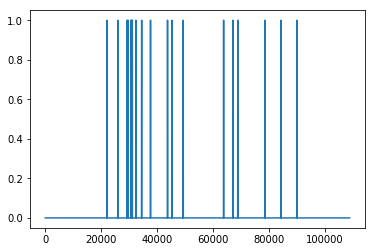

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read Data
df_model = pd.read_csv('df_model.csv')

# Distribution of Failures
print("# Failure Instances -- ", df_model.loc[df_model['FLG_FAIL']==1, ['DATE']].nunique())
plt.plot(range(df_model.shape[0]), df_model['FLG_FAIL']) # There is a period of close failures in the data.

In [2]:
df_model.drop(['DATE', 'TIMESTAMP'], axis=1, inplace=True)

train_indx = range(0, 60000)
val_indx = range(60000, 75000)
test_indx = range(75000, df_model.shape[0])

# Normalize the data using train stat

num_cols = df_model.columns[df_model.dtypes =='float64']

mean = df_model.loc[train_indx, num_cols].mean(axis = 0)
sd = df_model.loc[train_indx, num_cols].std(axis = 0)

df_model[num_cols] = df_model[num_cols] - mean
df_model[num_cols] = df_model[num_cols]/sd

df_model = np.array(df_model)

In [3]:
# Data needs to be sampled because of hardware constraint. 
# Even with a poweful GPU, model training ETA is over 24 hours.
# Sample - 1 obs every 1 hour. Reducing the size by 1/6th. Not the most optimal solution though

# generator to parameterize lookback and lookforward period and produce 3d tensor for time series analysis

# lookback - how many time stamps the data goes back to for each observation prediction
# delay - how many timestamps in future to predict
# min_index, max_index - index in to control timesteps to draw from
# step = 6 - sample every 6th observation

def data_gen(data, lookback, delay, min_index, max_index,batch_size=256, step=6):
    st = min_index + lookback # starting point
    end = max(max_index, st+batch_size) # end point
    rows = np.arange(st, end, step) # row index -- introduced a step of 6
    
    st = st + len(rows)
    
    while True:
        samples = np.zeros((len(rows), lookback//step, data.shape[-1])) #3d tensor for each timepoint with lookback
        target = np.zeros((len(rows,)))

        for i, row in enumerate(rows): #draw data
            indx = range(rows[i] - lookback, rows[i], step)
            samples[i] = data[indx]
            target[i] = data[rows[i] + delay][-1]
        yield samples, target            

In [4]:
# Generators for train, validation, and test

lookback = 288 # 2 days
delay = 144 # predict for next day
batch_size=256
step=6


train_gen = data_gen(data=df_model, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=min(train_indx), 
                     max_index=max(train_indx),
                    batch_size=batch_size,
                    step=6)

val_gen = data_gen(data=df_model, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=min(val_indx), 
                     max_index=max(val_indx),
                    batch_size=batch_size,
                  step=6)

test_gen = data_gen(data=df_model, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=min(test_indx), 
                     max_index=max(test_indx),
                    batch_size=batch_size,
                   step=6)

val_steps = (max(val_indx) - min(val_indx) - lookback)//(batch_size)
test_steps = (max(test_indx) - min(test_indx) - lookback)//(batch_size)

## Simple Dense NN

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

m1 = Sequential()
m1.add(layers.Flatten(input_shape=(lookback//step, df_model.shape[-1])))
m1.add(layers.Dense(16, activation='relu'))
#m1.add(layers.Dense(16, activation='relu'))
m1.add(layers.Dense(1, activation='sigmoid'))

m1.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['binary_accuracy'])

history = m1.fit_generator(train_gen,
                          epochs = 20,
                          steps_per_epoch=500,
                          validation_data=val_gen,
                          validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 220s 440ms/step - loss: 0.0152 - binary_accuracy: 0.9957 - val_loss: 0.1135 - val_binary_accuracy: 0.9759
Epoch 2/20
500/500 [==============================] - 217s 435ms/step - loss: 0.0058 - binary_accuracy: 0.9988 - val_loss: 0.2073 - val_binary_accuracy: 0.9641
Epoch 3/20
500/500 [==============================] - 216s 432ms/step - loss: 0.0035 - binary_accuracy: 0.9995 - val_loss: 0.2464 - val_binary_accuracy: 0.9343
Epoch 4/20
500/500 [==============================] - 218s 436ms/step - loss: 0.0023 - binary_accuracy: 0.9998 - val_loss: 0.2662 - val_binary_accuracy: 0.9331
Epoch 5/20
500/500 [==============================] - 216s 433ms/step - loss: 0.0015 - binary_accuracy: 0.9998 - val_loss: 0.2721 - val_binary_accuracy: 0.9360
Epoch 6/20
500/500 [==============================] - 220s 439ms/step - loss: 0.0011 - binary_accuracy: 0.9999 - val_loss: 0.2951 - val_binary_accuracy: 0.9335
Epoch 7/20
500/500 [====================

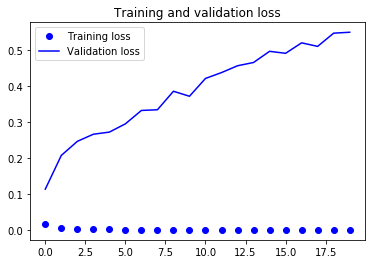

In [12]:
# Loss for train vs Test

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Un-regularized RNN

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

m2 = Sequential()
m2.add(layers.GRU(32, input_shape=(None, df_model.shape[-1])))
m2.add(layers.Dense(1, activation='sigmoid'))

m2.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['binary_accuracy'])

history = m2.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 224s 448ms/step - loss: 0.0256 - binary_accuracy: 0.9926 - val_loss: 0.1568 - val_binary_accuracy: 0.9454
Epoch 2/20
500/500 [==============================] - 220s 440ms/step - loss: 0.0041 - binary_accuracy: 0.9986 - val_loss: 0.2342 - val_binary_accuracy: 0.9299
Epoch 3/20
500/500 [==============================] - 221s 441ms/step - loss: 0.0019 - binary_accuracy: 0.9994 - val_loss: 0.3467 - val_binary_accuracy: 0.9201
Epoch 4/20
500/500 [==============================] - 220s 440ms/step - loss: 0.0010 - binary_accuracy: 0.9997 - val_loss: 0.3497 - val_binary_accuracy: 0.9335
Epoch 5/20
500/500 [==============================] - 220s 439ms/step - loss: 6.5921e-04 - binary_accuracy: 0.9998 - val_loss: 0.5446 - val_binary_accuracy: 0.9135
Epoch 6/20
500/500 [==============================] - 219s 439ms/step - loss: 4.8370e-04 - binary_accuracy: 0.9999 - val_loss: 0.5808 - val_binary_accuracy: 0.9168
Epoch 7/20
500/500 [============

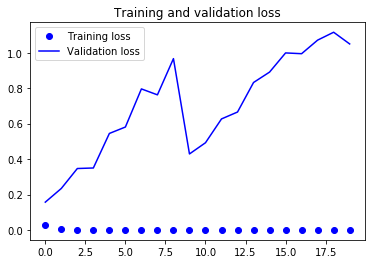

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()